In [1]:

import random
import time

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torch.utils.tensorboard import SummaryWriter

from seq2seq.transformers import helpers
from seq2seq import utils

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import seaborn as sns
# sns.set() Problems with attention


In [2]:
# Names
EXPERIMENT_NAME = "runs/transformer"
MODEL_NAME = "simple_transformer"

# Build model and initialize
DATASET_NAME = "miguel"  # multi30k, miguel
DATASET_PATH = f"../../.data/{DATASET_NAME}"
ALLOW_DATA_PARALLELISM = False
MAX_SRC_LENGTH = 100 + 2  # Doesn't include <sos>, <eos>
MAX_TRG_LENGTH = 100 + 2  # Doesn't include <sos>, <eos>
MAX_TRG_LENGTH_TEST = int(MAX_TRG_LENGTH * 1.0)  # len>1.0 is not supported by all models
CHECKPOINT_PATH = f'../checkpoints/simple_transformer_2.pt'
SOS_WORD = '<sos>'
EOS_WORD = '<eos>'

In [3]:
# Set fields
SRC = data.Field(tokenize='spacy', tokenizer_language="en", init_token=SOS_WORD, eos_token=EOS_WORD, lower=True, batch_first=True)
TRG = data.Field(tokenize='spacy', tokenizer_language="es", init_token=SOS_WORD, eos_token=EOS_WORD, lower=True, batch_first=True)
fields = [('src', SRC), ('trg', TRG)]

# Load vocabulary
src_vocab = utils.load_vocabulary(f'{DATASET_PATH}/tokenized/src_vocab.pkl')
trg_vocab = utils.load_vocabulary(f'{DATASET_PATH}/tokenized/trg_vocab.pkl')
print("Vocabularies loaded!")

# Add vocabularies to fields
SRC.vocab = src_vocab
TRG.vocab = trg_vocab
print(f"Unique tokens in source (en) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (es) vocabulary: {len(TRG.vocab)}")

/home/salvacarrion/anaconda3/envs/mltests/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/salvacarrion/anaconda3/envs/mltests/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Vocabularies loaded!
Unique tokens in source (en) vocabulary: 10000
Unique tokens in target (es) vocabulary: 10000


In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(utils.gpu_info())

- Using GPU: True
- No. devices: 1
- Device name (0): GeForce GTX 1070


In [5]:
from seq2seq.models import s2s_6_transfomer as builder
model = builder.make_model(src_field=SRC, trg_field=TRG,
                           max_src_len=MAX_SRC_LENGTH, max_trg_len=MAX_TRG_LENGTH, device=device,
                           data_parallelism=ALLOW_DATA_PARALLELISM)


# Load best model
model.load_state_dict(torch.load(CHECKPOINT_PATH))
print("Model loaded!")

# Set for evaluation
model.eval()

The model has 11,695,888 trainable parameters
Data parallelism: False
Model loaded!


Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(10000, 256)
    (pos_embedding): Embedding(102, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [6]:
sentence = "The agreement of the European Economic Area in August 1992."
(src_tokens, trans_tokens), attns = model.translate(sentence, max_length=MAX_TRG_LENGTH_TEST)

In [7]:
src = " ".join(src_tokens[1:-1])
trg = " ".join(trans_tokens[:-1])
print(f"Original: {src}")
print(f"Translation: {trg}")

Original: the agreement of the european economic area in august 1992 .
Translation: el acuerdo del espacio económico europeo en agosto de 1992 .


In [8]:
def display_attention(sentence, translation, attention, savepath=None, title="Attention"):
    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.add_subplot(111)

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + sentence, rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_title(title)
    ax.set_xlabel("Source")
    ax.set_ylabel("Translation")

    # Save figure
    if savepath:
        plt.savefig(savepath)
        print("save attention!")

    plt.show()
    plt.close()

In [9]:
def normalize(vector):
    min_v = torch.min(vector)
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        normalised = (vector - min_v) / range_v
    else:
        normalised = torch.zeros(vector.size())
    return normalised


<ipython-input-8-61d40568d26c>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, rotation=45)
<ipython-input-8-61d40568d26c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


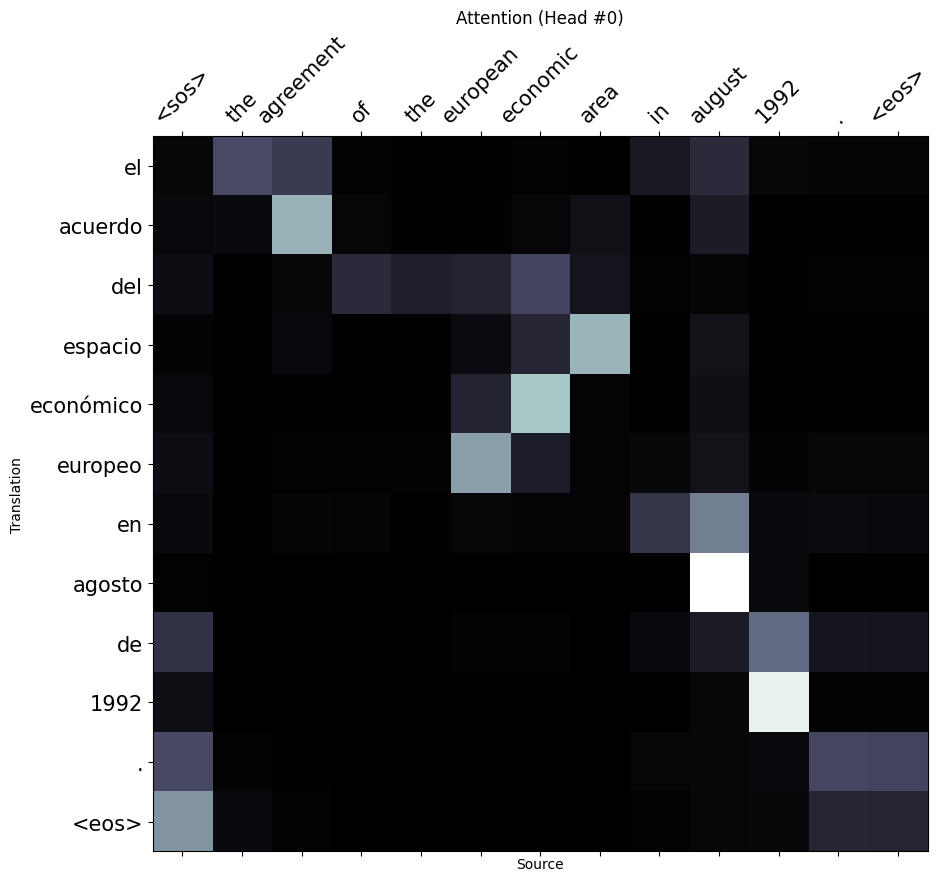

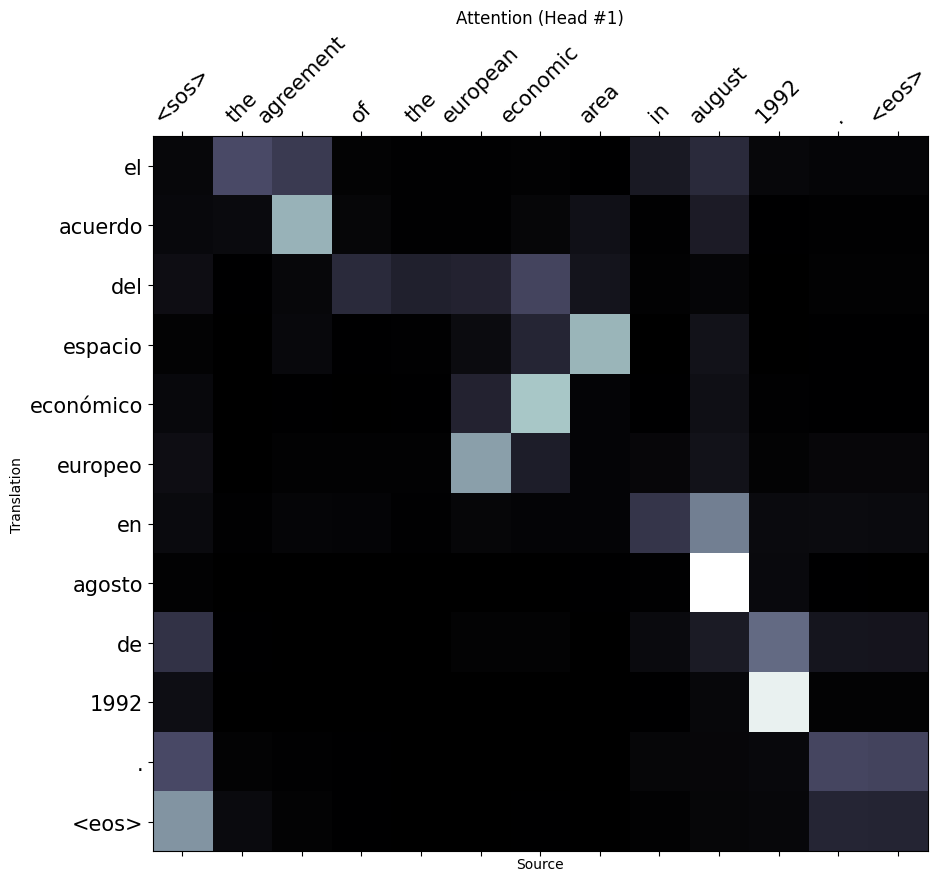

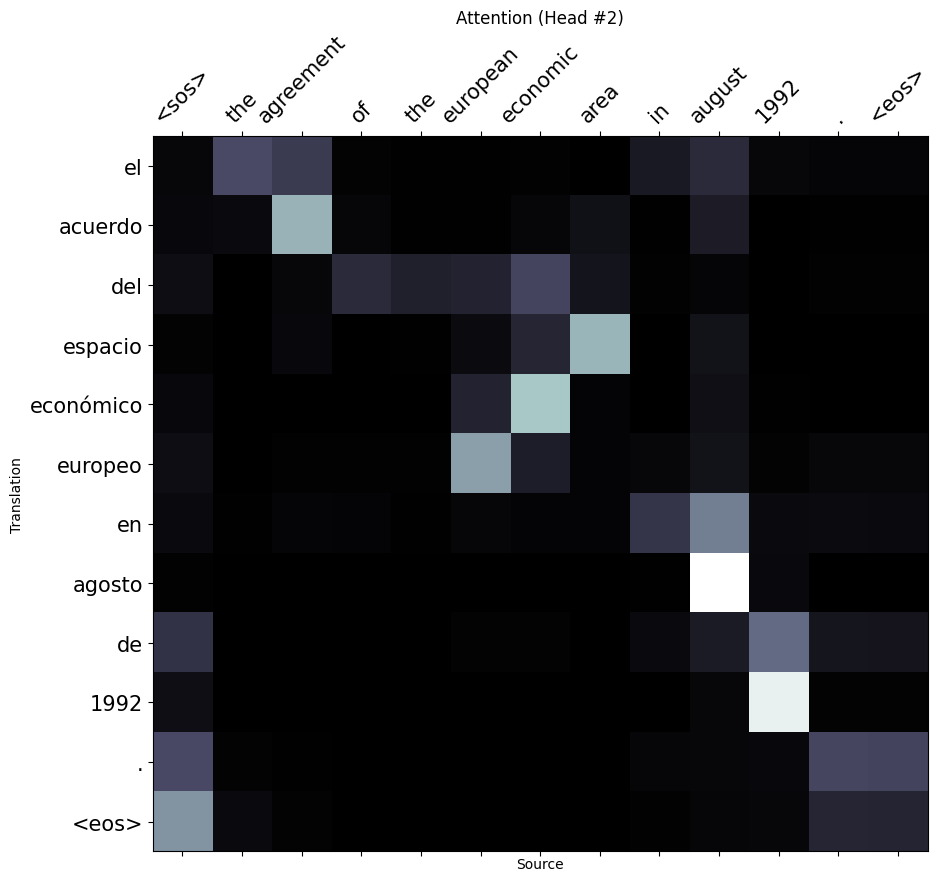

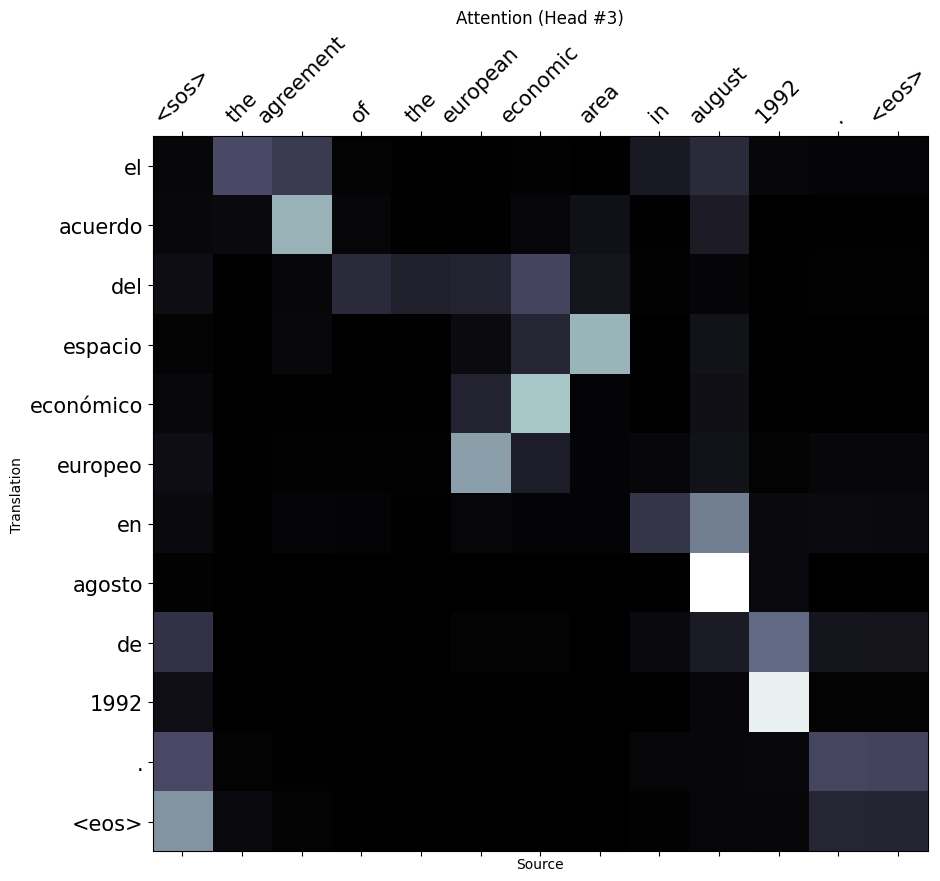

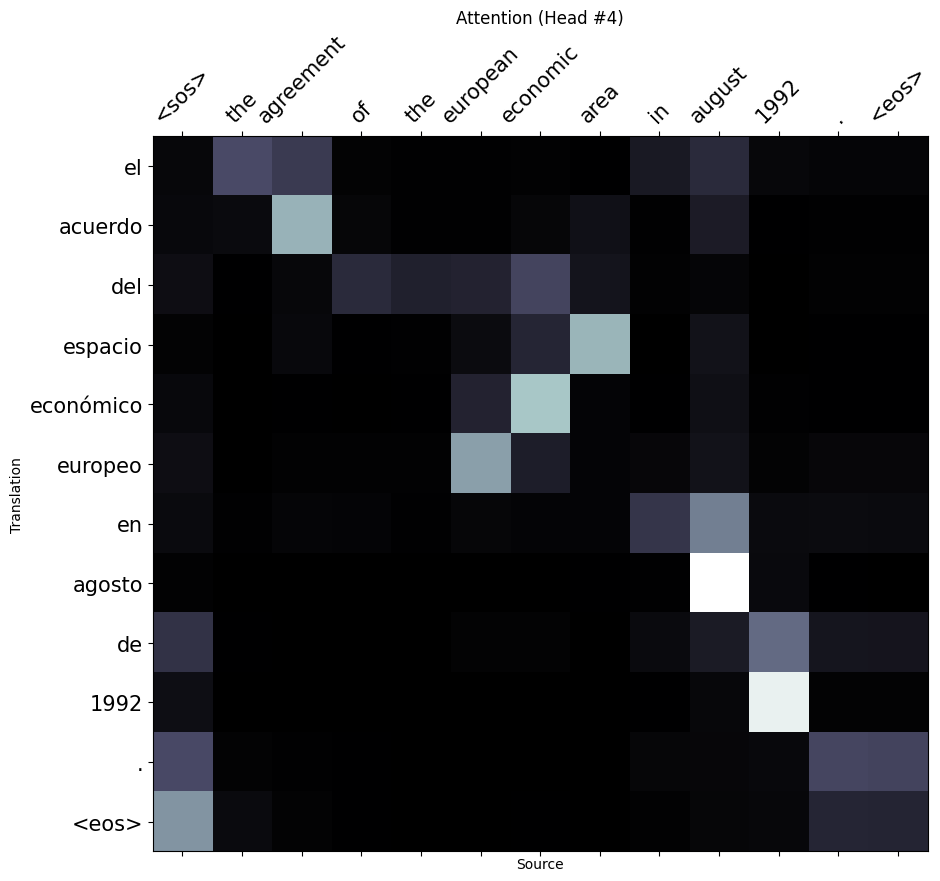

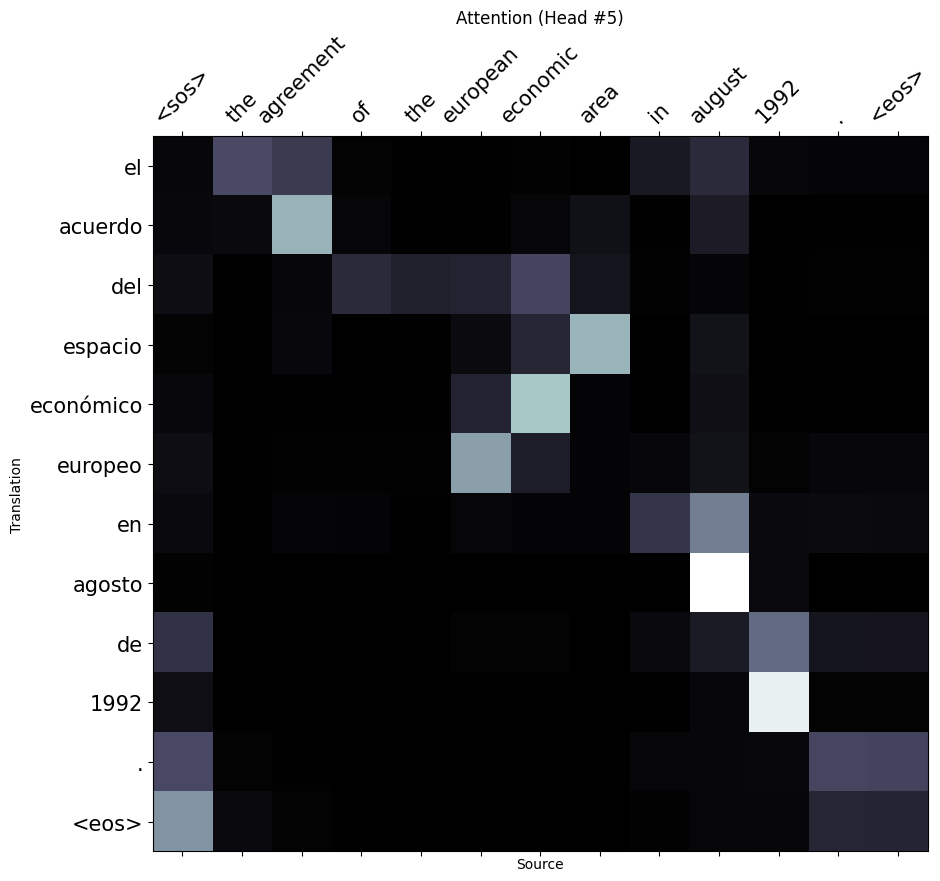

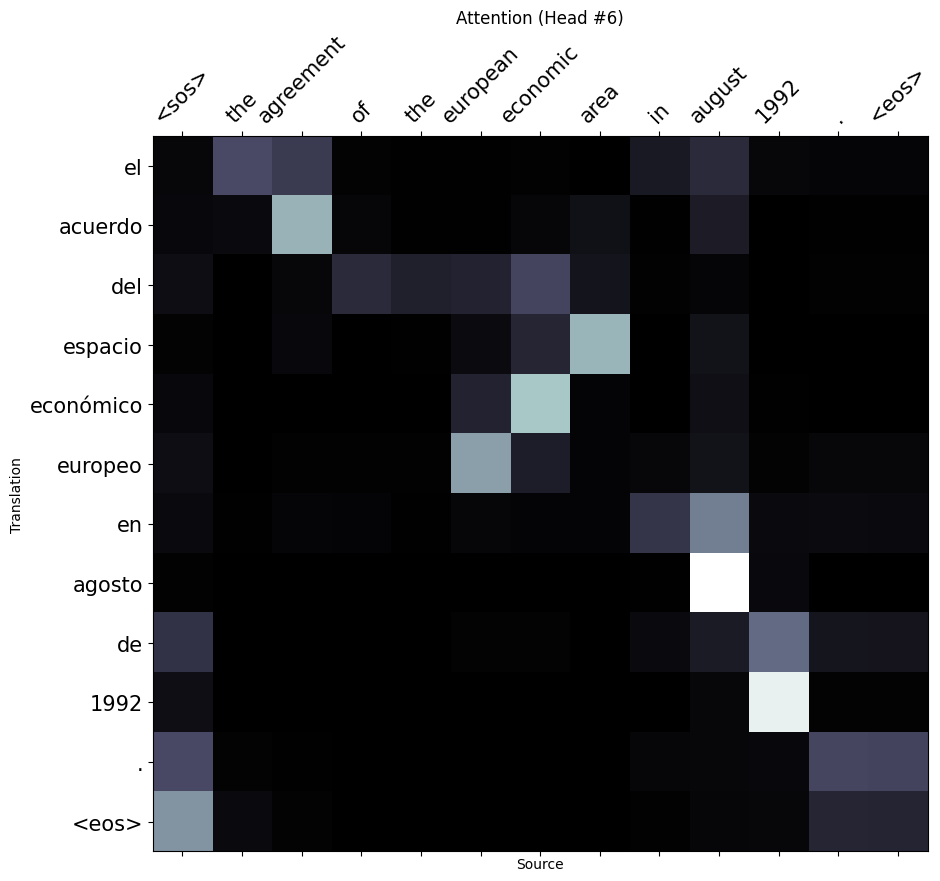

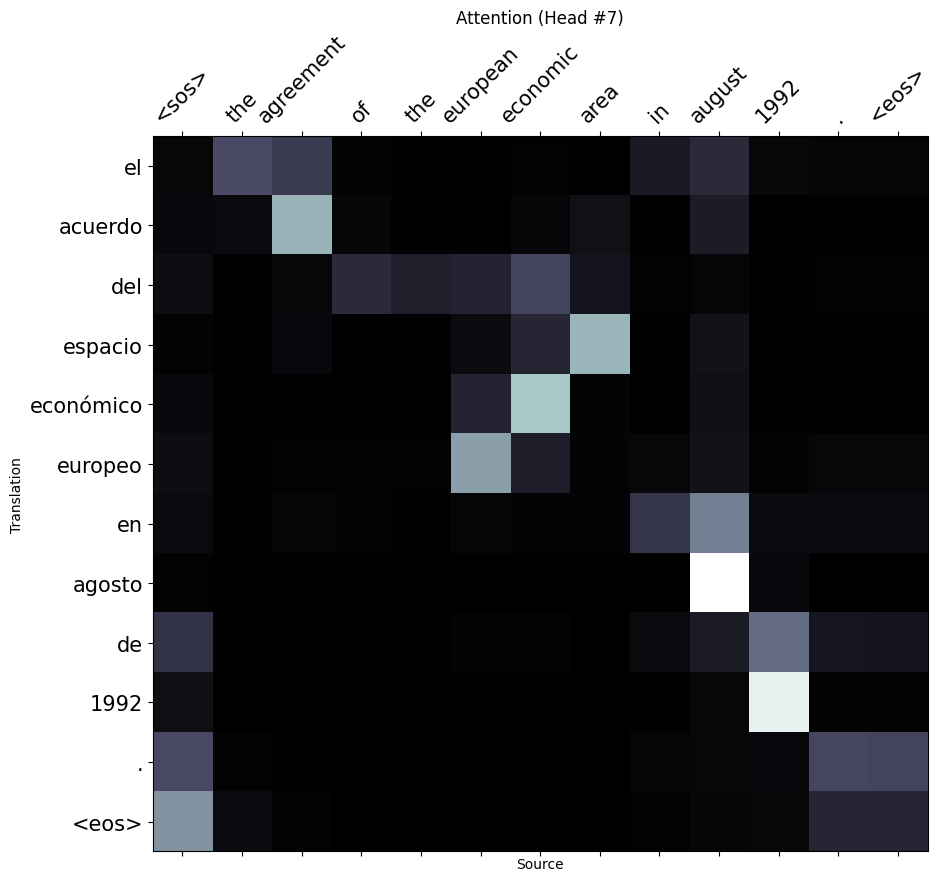

In [10]:
# Show attention
heads_attn = attns[0]
attn_avg = torch.mean(heads_attn, dim=0)
for i, attn_head in enumerate(heads_attn):  # Batch zero
    display_attention(src_tokens, trans_tokens, attn_avg, title=f"Attention (Head #{i})")

/home/salvacarrion/Documents/Programming/Python/mltests/seq2seq/utils.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels([''] + sentence, rotation=45)
/home/salvacarrion/Documents/Programming/Python/mltests/seq2seq/utils.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_yticklabels([''] + translation)


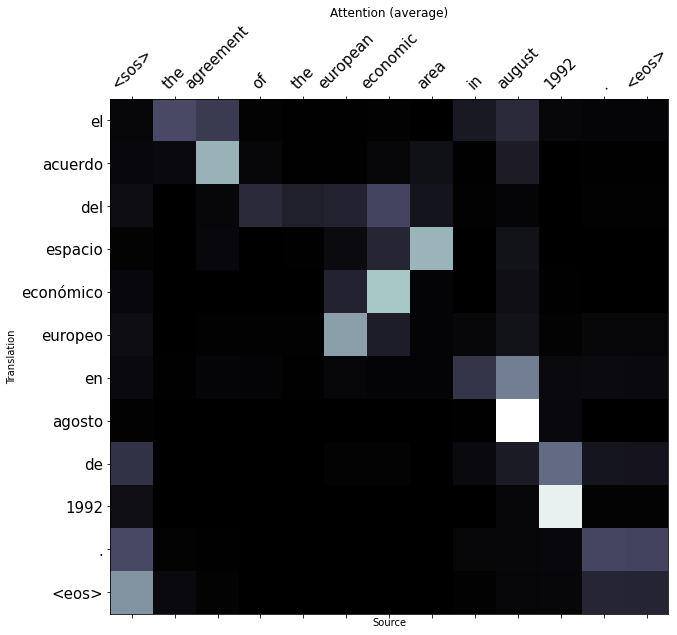

In [14]:
# Get first one
heads_attn = attns[0]
attn_avg = torch.mean(heads_attn, dim=0)

utils.display_attention(src_tokens, trans_tokens, attn_avg, title=f"Attention (average)")

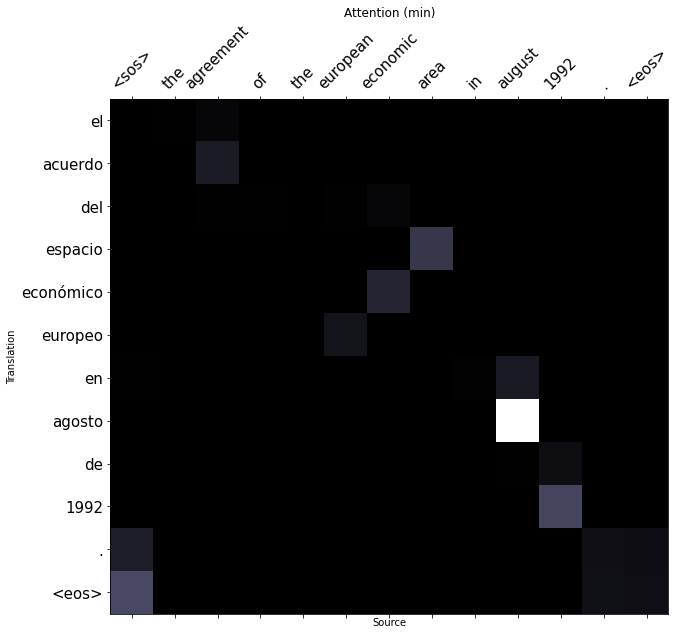

In [12]:
# Get first one
heads_attn = attns[0]
attn_min = torch.min(heads_attn, dim=0)[0]

utils.display_attention(src_tokens, trans_tokens, attn_min, title=f"Attention (min)")


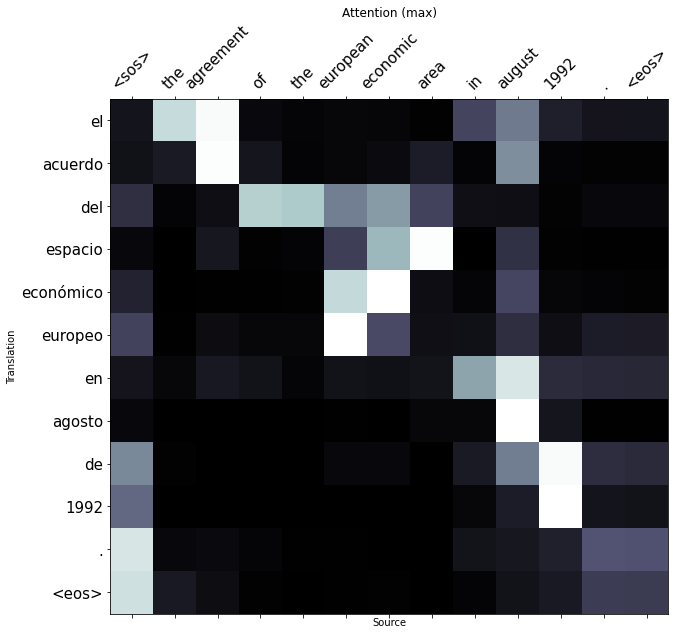

In [13]:
# Get first one
heads_attn = attns[0]
attn_max = torch.max(heads_attn, dim=0)[0]

utils.display_attention(src_tokens, trans_tokens, attn_max, title=f"Attention (max)")

